In [1]:
%reload_ext autoreload
%autoreload 2

# Stim class

In [17]:
from soft_info import RepetitionCodeStimCircuit

d = 3
T = 3
resets = False
xbasis = False
logical = '0'
subsampling = False

s_m = 0.5
noise_list = [2e-2, 1e-3, 0.2e-2, 0.5e-2, 2e-2, 2e-2*(1-s_m), 2e-2*s_m] # [twog_err, sglg_err, t1_err, t2_err, readout_err, hard_err, soft_err]
# noise_list = [2e-2, 1e-3, 0.2e-2, 0.5e-2, 2e-2, 0, 2e-2*s_m] # [twog_err, sglg_err, t1_err, t2_err, readout_err, hard_err, soft_err]
# noise_list = None

code = RepetitionCodeStimCircuit(d, T, xbasis=xbasis, resets=resets, noise_list=noise_list, subsampling=subsampling)

circuit = code.circuits[logical]
print(circuit)

R 0 1 2 3 4
TICK
PAULI_CHANNEL_1(0.001, 0.001, 0.005) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.02) 0 1 2 3
TICK
CX 2 1 4 3
DEPOLARIZE2(0.02) 2 1 4 3
TICK
X_ERROR(0.01) 1 3
M(0.01) 1 3
DETECTOR(2, 0) rec[-2]
DETECTOR(4, 0) rec[-1]
SHIFT_COORDS(0, 1)
PAULI_CHANNEL_1(0.001, 0.001, 0.005) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.02) 0 1 2 3
TICK
CX 2 1 4 3
DEPOLARIZE2(0.02) 2 1 4 3
TICK
X_ERROR(0.01) 1 3
M(0.01) 1 3
DETECTOR(2, 0) rec[-2]
DETECTOR(4, 0) rec[-1]
SHIFT_COORDS(0, 1)
PAULI_CHANNEL_1(0.001, 0.001, 0.005) 0 2 4
CX 0 1 2 3
DEPOLARIZE2(0.02) 0 1 2 3
TICK
CX 2 1 4 3
DEPOLARIZE2(0.02) 2 1 4 3
TICK
X_ERROR(0.01) 1 3
M(0.01) 1 3
DETECTOR(2, 0) rec[-2] rec[-6]
DETECTOR(4, 0) rec[-1] rec[-5]
SHIFT_COORDS(0, 1)
X_ERROR(0.01) 0 2 4
M(0.01) 0 2 4
DETECTOR(2, 0) rec[-3] rec[-2] rec[-5] rec[-7]
DETECTOR(4, 0) rec[-2] rec[-1] rec[-4] rec[-6]
OBSERVABLE_INCLUDE(0) rec[-1]


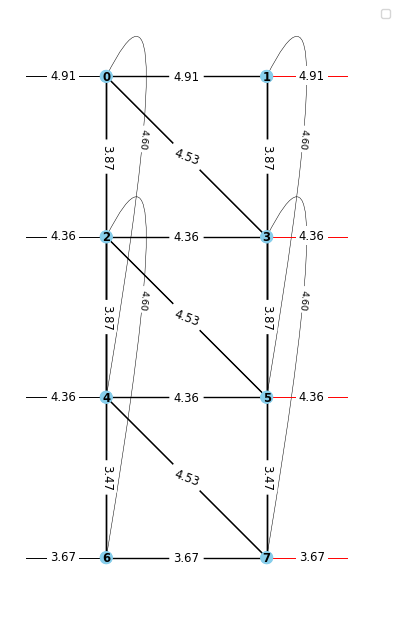

In [18]:
from soft_info import draw_matching_graph
import pymatching

model = circuit.detector_error_model(decompose_errors=False, ignore_decomposition_failures=False)
matching = pymatching.Matching(model)
model.to_file('model.stim')

draw_matching_graph(matching, d, T, figsize=(6, 6), scale_factor=0.7, dpi=100)

In [5]:
matching.edges()

[(0,
  None,
  {'fault_ids': set(),
   'weight': 3.65752353366513,
   'error_probability': 0.02514760188033175}),
 (0,
  1,
  {'fault_ids': set(),
   'weight': 3.65752353366513,
   'error_probability': 0.02514760188033175}),
 (0,
  2,
  {'fault_ids': set(),
   'weight': 3.868944011214244,
   'error_probability': 0.02045333333333343}),
 (0,
  3,
  {'fault_ids': set(),
   'weight': 4.529907701487534,
   'error_probability': 0.01066666666666677}),
 (0,
  4,
  {'fault_ids': set(), 'weight': 4.59511985013459, 'error_probability': 0.01}),
 (1,
  3,
  {'fault_ids': set(),
   'weight': 3.868944011214244,
   'error_probability': 0.02045333333333343}),
 (1,
  5,
  {'fault_ids': set(), 'weight': 4.59511985013459, 'error_probability': 0.01}),
 (1,
  None,
  {'fault_ids': {0},
   'weight': 3.65752353366513,
   'error_probability': 0.02514760188033175}),
 (2,
  None,
  {'fault_ids': set(),
   'weight': 3.467883066891638,
   'error_probability': 0.03024000000000013}),
 (2,
  3,
  {'fault_ids': set(),

In [6]:
model.diagram(type="match-graph-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":42,"max":[12,17.3205032348633,0],"min":[-2.9442720413208,-8.32050228118896,0],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":8,"max":[20.9442710876465,17.3205032348633,0],"min":[12,-8.32050228118896,0],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":504,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":96,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":504,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AADAQAAAAAAAAAAAYO/nPscgBcEAAAAAAADAQAAAAAAAAAAAAABAQQAAAAAAAAAAAADAQAAAAAAAAAAAAADAQAAAQEAAAAAAAADAQAAAAAAAAAAAAABAQQAAQEAAAAAAAADAQAAAAAAAAAAAAADAQAAAwEAAAAAAAABAQQAAAAAAAAAAAABAQQAAQEAAAAAAAABAQQAAAAAAAAAAAABAQQAAwEAAAAAAAADAQAAAQEAAAAAA9G48wPRuvL8AAAAAAADAQAAAQEAAAAAAAABAQQAAQEAAAAAAAADAQAAAQEAAAAAAAADAQAAAwEAAAAAAAADAQAAAQEAAAAAAAABAQQAAwEAAAAAAAADAQAAAQEAAAAAAAADAQAAAEEEAAAAAAABAQQAAQEAAAAAAAABAQQAAwEAAAAAAAABAQQAAQEAAAAAAAABAQQAAEEEAAAAAAADAQAAAwEAAAAAA9G48wN6NJ0EAAAAAAADAQAAAwEAAAAAAAABAQQAAwEAAAAAAAADAQAAAwEAAAAAAAADAQAAAEEEAAAAAAADAQAAAwEAAAAAAAABAQQAAEEEAAAAAAABAQQAAwEAAAAAAAABAQQAAEEEAAAAAAADAQAAAEEEAAAAAYO/nPmSQikEAAAAAAADAQAAAEEEAAAAAAABAQQAAEEEAAAAA"},{"byteLength":96,"name":"buf_red_scattered_lines","uri":"data:application/octet-stream;base64,AABAQQAAAAAAAAAAQmCMQccgBcEAAAAAAABAQQAAQEAAAAAA3o2nQfRuvL8AAAAAAABAQQAAwEAAAAAA3o2nQd6NJ0EAAAAAAABAQQAAEEEAAAAAQmCMQWSQikEAAAAA"}],"materials":[{"doubleSided":true,"name":"black","pbrMetallicRoughness":{"baseColorFactor":[0,0,0,1],"metallicFactor":1,"roughnessFactor":1}},{"doubleSided":true,"name":"black","pbrMetallicRoughness":{"baseColorFactor":[0,0,0,1],"metallicFactor":1,"roughnessFactor":1}},{"doubleSided":true,"name":"red","pbrMetallicRoughness":{"baseColorFactor":[1,0,0,1],"metallicFactor":1,"roughnessFactor":1}}],"meshes":[{"primitives":[{"attributes":{"POSITION":0},"material":0,"mode":6}]},{"primitives":[{"attributes":{"POSITION":1},"material":1,"mode":1}]},{"primitives":[{"attributes":{"POSITION":2},"material":2,"mode":1}]}],"nodes":[{"mesh":0,"translation":[6,0,0]},{"mesh":0,"translation":[12,0,0]},{"mesh":0,"translation":[6,3,0]},{"mesh":0,"translation":[12,3,0]},{"mesh":0,"translation":[6,6,0]},{"mesh":0,"translation":[12,6,0]},{"mesh":0,"translation":[6,9,0]},{"mesh":0,"translation":[12,9,0]},{"mesh":1,"translation":[0,0,0]},{"mesh":2,"translation":[0,0,0]}],"scene":0,"scenes":[{"nodes":[0,1,2,3,4,5,6,7,8,9]}]}

# Stim circuit

In [ ]:
import stim 

circuit_nf = stim.Circuit.generated("repetition_code:memory", distance=d, rounds=T)
print(circuit_nf)

In [ ]:
import pymatching
d=4
T=4

avg_noise = {"two_gate": 0.02, "readout": 0.02, "idle": 0.03, "reset": 0.02}

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=d,
                                rounds=T,
                                after_clifford_depolarization=avg_noise["two_gate"], #two-qubit-fidelity,
                                after_reset_flip_probability=avg_noise["reset"], #reset error,
                                before_measure_flip_probability=avg_noise["readout"], #measurement error,
                                before_round_data_depolarization=avg_noise["idle"]) #idle error)

model = circuit.detector_error_model(decompose_errors=False)
matching = pymatching.Matching.from_detector_error_model(model)

draw_matching_graph(matching, d, T, figsize=(5, 5), scale_factor=0.5)
print(circuit)

In [ ]:
print(circuit)

# Get backend noise

In [ ]:
from soft_info import get_avgs_from_dict, get_noise_dict_from_backend, get_repcode_layout
from result_saver import SaverProvider

provider = SaverProvider()
layout = get_repcode_layout(distance=50, backend=provider.get_backend("ibm_sherbrooke"), _is_hex=True)

In [ ]:
avg_noise = get_avgs_from_dict(get_noise_dict_from_backend(provider, device="ibm_sherbrooke", 
                                                           used_qubits=None, date='2023-10-30'), used_qubits=layout)
print(avg_noise)

In [ ]:
avg_noise = get_avgs_from_dict(get_noise_dict_from_backend(provider, device="ibm_sherbrooke", 
                                                           used_qubits=layout, date='2023-10-30'), used_qubits=layout)
print(avg_noise)